# Texture classification using MR8 filter bank


In [3]:
import numpy as np
import os
import cv2 as cv
import scipy
from scipy.signal import convolve2d
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle

## Loading the data

In [5]:
!wget http://www.robots.ox.ac.uk/~vgg/research/texclass/data/curetgrey.zip
!unzip curetgrey.zip

/sample57/57-042.png  
 extracting: curetgrey/sample57/57-043.png  
  inflating: curetgrey/sample57/57-044.png  
  inflating: curetgrey/sample57/57-045.png  
  inflating: curetgrey/sample57/57-046.png  
  inflating: curetgrey/sample57/57-047.png  
  inflating: curetgrey/sample57/57-048.png  
  inflating: curetgrey/sample57/57-049.png  
  inflating: curetgrey/sample57/57-050.png  
  inflating: curetgrey/sample57/57-051.png  
  inflating: curetgrey/sample57/57-052.png  
  inflating: curetgrey/sample57/57-053.png  
  inflating: curetgrey/sample57/57-054.png  
  inflating: curetgrey/sample57/57-055.png  
 extracting: curetgrey/sample57/57-057.png  
 extracting: curetgrey/sample57/57-059.png  
 extracting: curetgrey/sample57/57-061.png  
 extracting: curetgrey/sample57/57-063.png  
 extracting: curetgrey/sample57/57-065.png  
 extracting: curetgrey/sample57/57-068.png  
 extracting: curetgrey/sample57/57-071.png  
 extracting: curetgrey/sample57/57-073.png  
 extracting: curetgrey/sample57/

In [5]:
samples_folders = os.listdir('curetgrey/')
data_path = [list(map(lambda x: f'curetgrey/{samples_folders[i]}/{x}',os.listdir(f'curetgrey/{samples_folders[i]}/'))) for i in range(len(samples_folders))]

data = []
cat_data = []
labels = []
for i in range(len(data_path)):
  cat_data += [[]]
  for path in data_path[i]:
    img = img = cv.imread(path, cv.IMREAD_GRAYSCALE)
    cat_data[i] = cat_data[i] + [img]
    data = data + [img]
    labels = labels + [i] 

data = np.array(data)
cat_data = np.array(cat_data)
labels = np.array(labels)

print(data.shape)
print(labels.shape)
print(cat_data.shape)

(5612, 200, 200)
(5612,)
(61, 92, 200, 200)


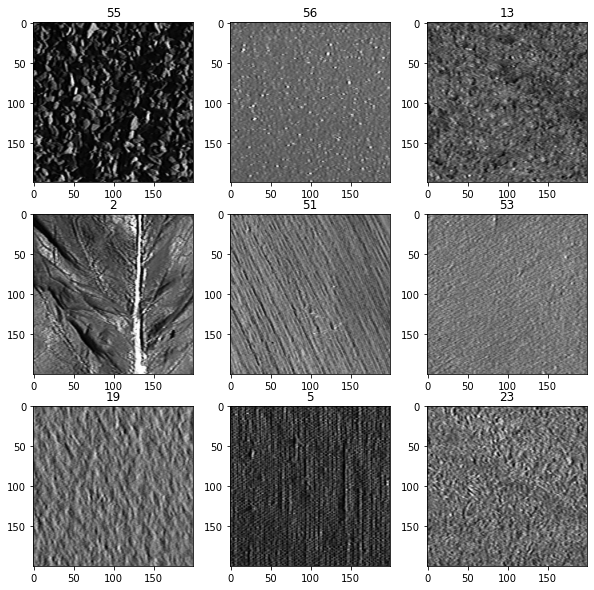

In [6]:
plt.figure(figsize=(10,10))
cnt = 1
for i in np.random.randint(0, 5612, 9):
  plt.subplot(3,3,cnt)
  plt.imshow(data[i], cmap='gray')
  plt.title(labels[i])
  cnt = cnt + 1
plt.show()

# Creating MR8 filterbank


In [9]:
def gaussian1d(sigma, mean, x, ord):
    x = np.array(x)
    x_ = x - mean
    var = sigma**2

    # Gaussian Function
    g1 = (1/np.sqrt(2*np.pi*var))*(np.exp((-1*x_*x_)/(2*var)))

    if ord == 0:
        g = g1
        return g
    elif ord == 1:
        g = -g1*((x_)/(var))
        return g
    else:
        g = g1*(((x_*x_) - var)/(var**2))
        return g

def gaussian2d(sup, scales):
    var = scales * scales
    shape = (sup,sup)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    return g

def log2d(sup, scales):
    var = scales * scales
    shape = (sup,sup)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    h = g*((x*x + y*y) - var)/(var**2)
    return h

def makefilter(scale, phasex, phasey, pts, sup):

    gx = gaussian1d(3*scale, 0, pts[0,...], phasex)
    gy = gaussian1d(scale,   0, pts[1,...], phasey)

    image = gx*gy

    image = np.reshape(image,(sup,sup))
    return image

def makeMR8filters():
    sup     = 49
    scalex  = np.sqrt(2) * np.array([1,2,3])
    norient = 6
    nrotinv = 2

    nbar  = len(scalex)*norient
    nedge = len(scalex)*norient
    nf    = nbar+nedge+nrotinv
    F     = np.zeros([sup,sup,nf])
    hsup  = (sup - 1)/2

    x = [np.arange(-hsup,hsup+1)]
    y = [np.arange(-hsup,hsup+1)]

    [x,y] = np.meshgrid(x,y)

    orgpts = [x.flatten(), y.flatten()]
    orgpts = np.array(orgpts)

    count = 0
    for scale in range(len(scalex)):
        for orient in range(norient):
            angle = (np.pi * orient)/norient
            c = np.cos(angle)
            s = np.sin(angle)
            rotpts = [[c+0,-s+0],[s+0,c+0]]
            rotpts = np.array(rotpts)
            rotpts = np.dot(rotpts,orgpts)
            F[:,:,count] = makefilter(scalex[scale], 0, 1, rotpts, sup)
            F[:,:,count+nedge] = makefilter(scalex[scale], 0, 2, rotpts, sup)
            count = count + 1
          
    count = nbar+nedge
    scales = np.sqrt(2) * np.array([1,2,3,4])

    F[:,:, count] = gaussian2d(sup, scales[-1])
    F[:,:, count+1] = log2d(sup, 3*scales[-1])

    return F

mr8 = makeMR8filters()
print(mr8.shape)

(49, 49, 38)


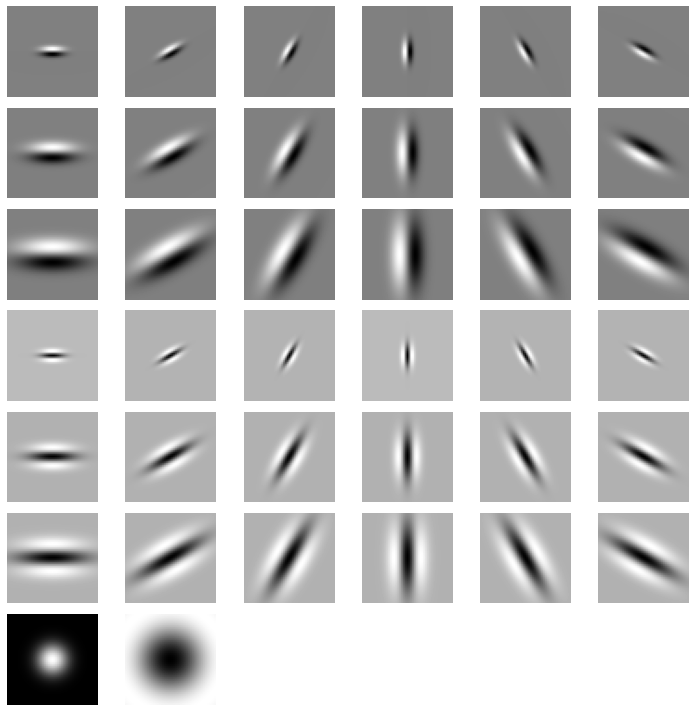

In [10]:
plt.figure(figsize=(10,10))
for i in range(38):
    plt.subplot(7,6, i+1)
    plt.imshow(mr8[:,:,i], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Building Textons and dictionary

## Step 1
Choosing 13 random images from each categorey and calculate filter response for each of them.

In [26]:
def get_mr8_responses(img:np)->np:
    ret = np.zeros((152,152,8))
    responses = []
    for i in range(38):
        kernel = mr8[:,:,i]
        res = convolve2d(img, kernel, 'valid')
        responses += [res]
    for i in range(6):
        max_response = i*6
        for j in range(6):
            if(np.mean(responses[i*6+j]) > np.mean(responses[max_response])):
                max_response = i*6+j
        ret[:,:,i] = responses[max_response]
    ret[:,:,6] = responses[36]
    ret[:,:,7] = responses[37]
    ret = np.array(ret)
    return ret

responses = [np.zeros((13,152,152,8)) for i in range(61)]
for i in tqdm(range(61)):
    cnt = 0
    for j in np.random.randint(0,92,13):
        responses[i][cnt,:,:,:] = get_mr8_responses(cat_data[i,j])
        cnt = cnt+1

responses = np.array(responses)
print(responses.shape)   
with open('responses.pkl', 'wb') as file:
    pickle.dump(responses, file)


(61, 13, 152, 152, 8)


## Step 2
Running K-Mean clustering algorithm on each categorey and calculate 10 texon

In [47]:
from sklearn.cluster import KMeans

def cal_hist(img:np)->np:
    hist = np.zeros((256))
    for i in range(152):
        for j in range(152):
            hist[int(img[i,j])] += 1
    return hist


responses_histograms = [[] for i in range(61)]
for i in range(61):
    for j in range(13):
        hists = []
        for k in range(8):
            img = responses[i,j,:,:,k]
            print(np.max(img))
            hists += [cal_hist(img)]
        hists = np.array(hists)
        responses_histograms[i] += [hists]
responses_histograms = np.array(responses_histograms)
print(responses_histograms.shape)

3.0277083015687456
0.6938595015894232
0.4115465387584009
2.0194820638649347
0.3149165573054751
0.11677548722675206
2046.180287556065


IndexError: index 2034 is out of bounds for axis 0 with size 256

In [ ]:
for i in range(61):
    kmean = KMeans(n_clusters=10)
    kmean.fit(responses_histograms[i])
    print(kmean.cluster_centers_)
